## 1. Multi-Class Classification

#### Imports

In [1]:
%matplotlib inline
import numpy as np
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.misc #Used to show matrix as an image
from scipy import optimize
from scipy.special import expit #Vectorized sigmoid function
import matplotlib.pyplot as plt
import matplotlib.cm as cm #Used to display images in a specific colormap
import random #To pick random images to display
from IPython.display import Image

#### Preparing the Data

In [2]:
# for lists the order is [columns, rows]
# for numpy array the order is [rows, columns]
# numpy count starts at 0

datafile = 'ex3data1.mat'
mat = scipy.io.loadmat( datafile )
X, y = mat['X'], mat['y']

# Insert a column of 1's to X
X = np.insert(X,0,1,axis=1)

# X.shape = (5000,400)
# There are 5000 training examples, each example is a 20 pixel by 20 pixel grayscale image of the digit.
# The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector.

In [3]:
np.unique(y)
# y is a 5000-dimensional vector that contains labels for the training set
# y.shape = (5000, 1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

#### Visualizing the Data

In [4]:
def get_img(row):
    """
    Function that is handed a single np array with shape 1x400,
    creates an image object from it, and returns it
    
    Again, there are 400 pixels in each image. It was originally represented in a 400-dimensional vector 
    from the raw data, but we want to convert it into a grid of 20x20 matrix
    """
    width, height = 20, 20
    square = row[1:].reshape(width, height) # converts 1x400 into 20x20
    return square.T

def display_data(numbers_to_display = None):
    """
    Function that picks 100 random rows from X, creates a 20x20 image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not numbers_to_display:
        numbers_to_display = random.sample(range(X.shape[0]), nrows*ncols) 
        # if "numbers_to_display" is not specified,
        # the randomly select 100 samples out of population of 5000 (the number of training examples)
    
    big_picture = np.zeros((height*nrows,width*ncols)) #big_picture.shape = (200, 200)
    """
    This part of the code below fills in the big_picture np.zeros with randomly selected training examples
    """
    irow, icol = 0, 0
    for idx in numbers_to_display: 
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = get_img(X[idx]) #running get_img for every training sample, in this case 100 samples
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        # don't completely understand this line above... 
        # but its basically broadcast input array from iimg into big_picture
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage(big_picture)
    plt.imshow(img,cmap = cm.Greys_r)
    
# logic of if not --> https://stackoverflow.com/questions/16739555/python-if-not-syntax
# scipy.misc.toimage --> Takes a numpy array and returns a PIL image
# shape[0] = # of rows | shape[1] = # of columns 

# big_picture.shape = (200,200)
# iimg.shape = (20,20)

/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


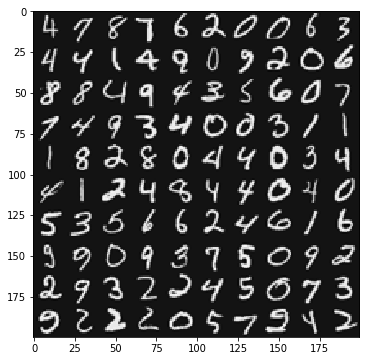

In [5]:
display_data()

#### Vectorizing Logistic Regression

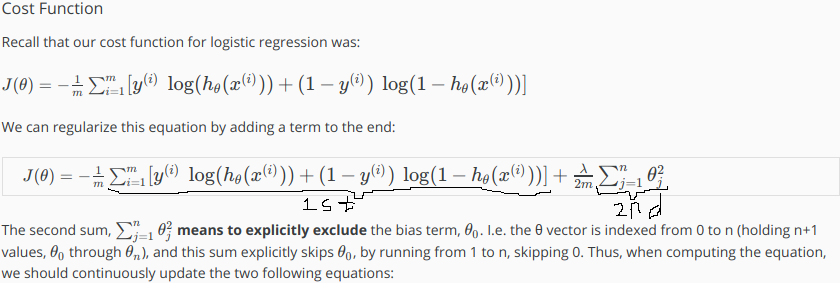

In [6]:
Image("Regularized_cost_function2.png", width=800, height=300)

In [7]:
#Hypothesis function and cost function for logistic regression
def hypothesis(mytheta,myX): #Logistic hypothesis function
    return expit(np.dot(myX,mytheta))

#A more simply written cost function, inspired by subokita:
def cost_function(mytheta,myX,myy,mylambda = 0.):
    m = myX.shape[0] #5000
    myh = hypothesis(mytheta,myX) #shape: (5000,1)
    term1 = np.log( myh ).dot( -myy.T ) #shape: (5000,5000)
    term2 = np.log( 1.0 - myh ).dot( 1 - myy.T ) #shape: (5000,5000)
    left_hand = (term1 - term2) / m #shape: (5000,5000)
    right_hand = mytheta.T.dot( mytheta ) * mylambda / (2*m) #shape: (1,1)
    return left_hand + right_hand #shape: (5000,5000)

# Difference between numpy.dot and a.dot(b) <-- https://stackoverflow.com/questions/42517281/difference-between-numpy-dot-and-a-dotb
# If type(a) is not numpy.ndarray, then numpy.dot will convert a to an array and use the array for the multiplication, 
# while a.dot will do whatever a's type says it does, or raise an AttributeError if a doesn't have a dot method

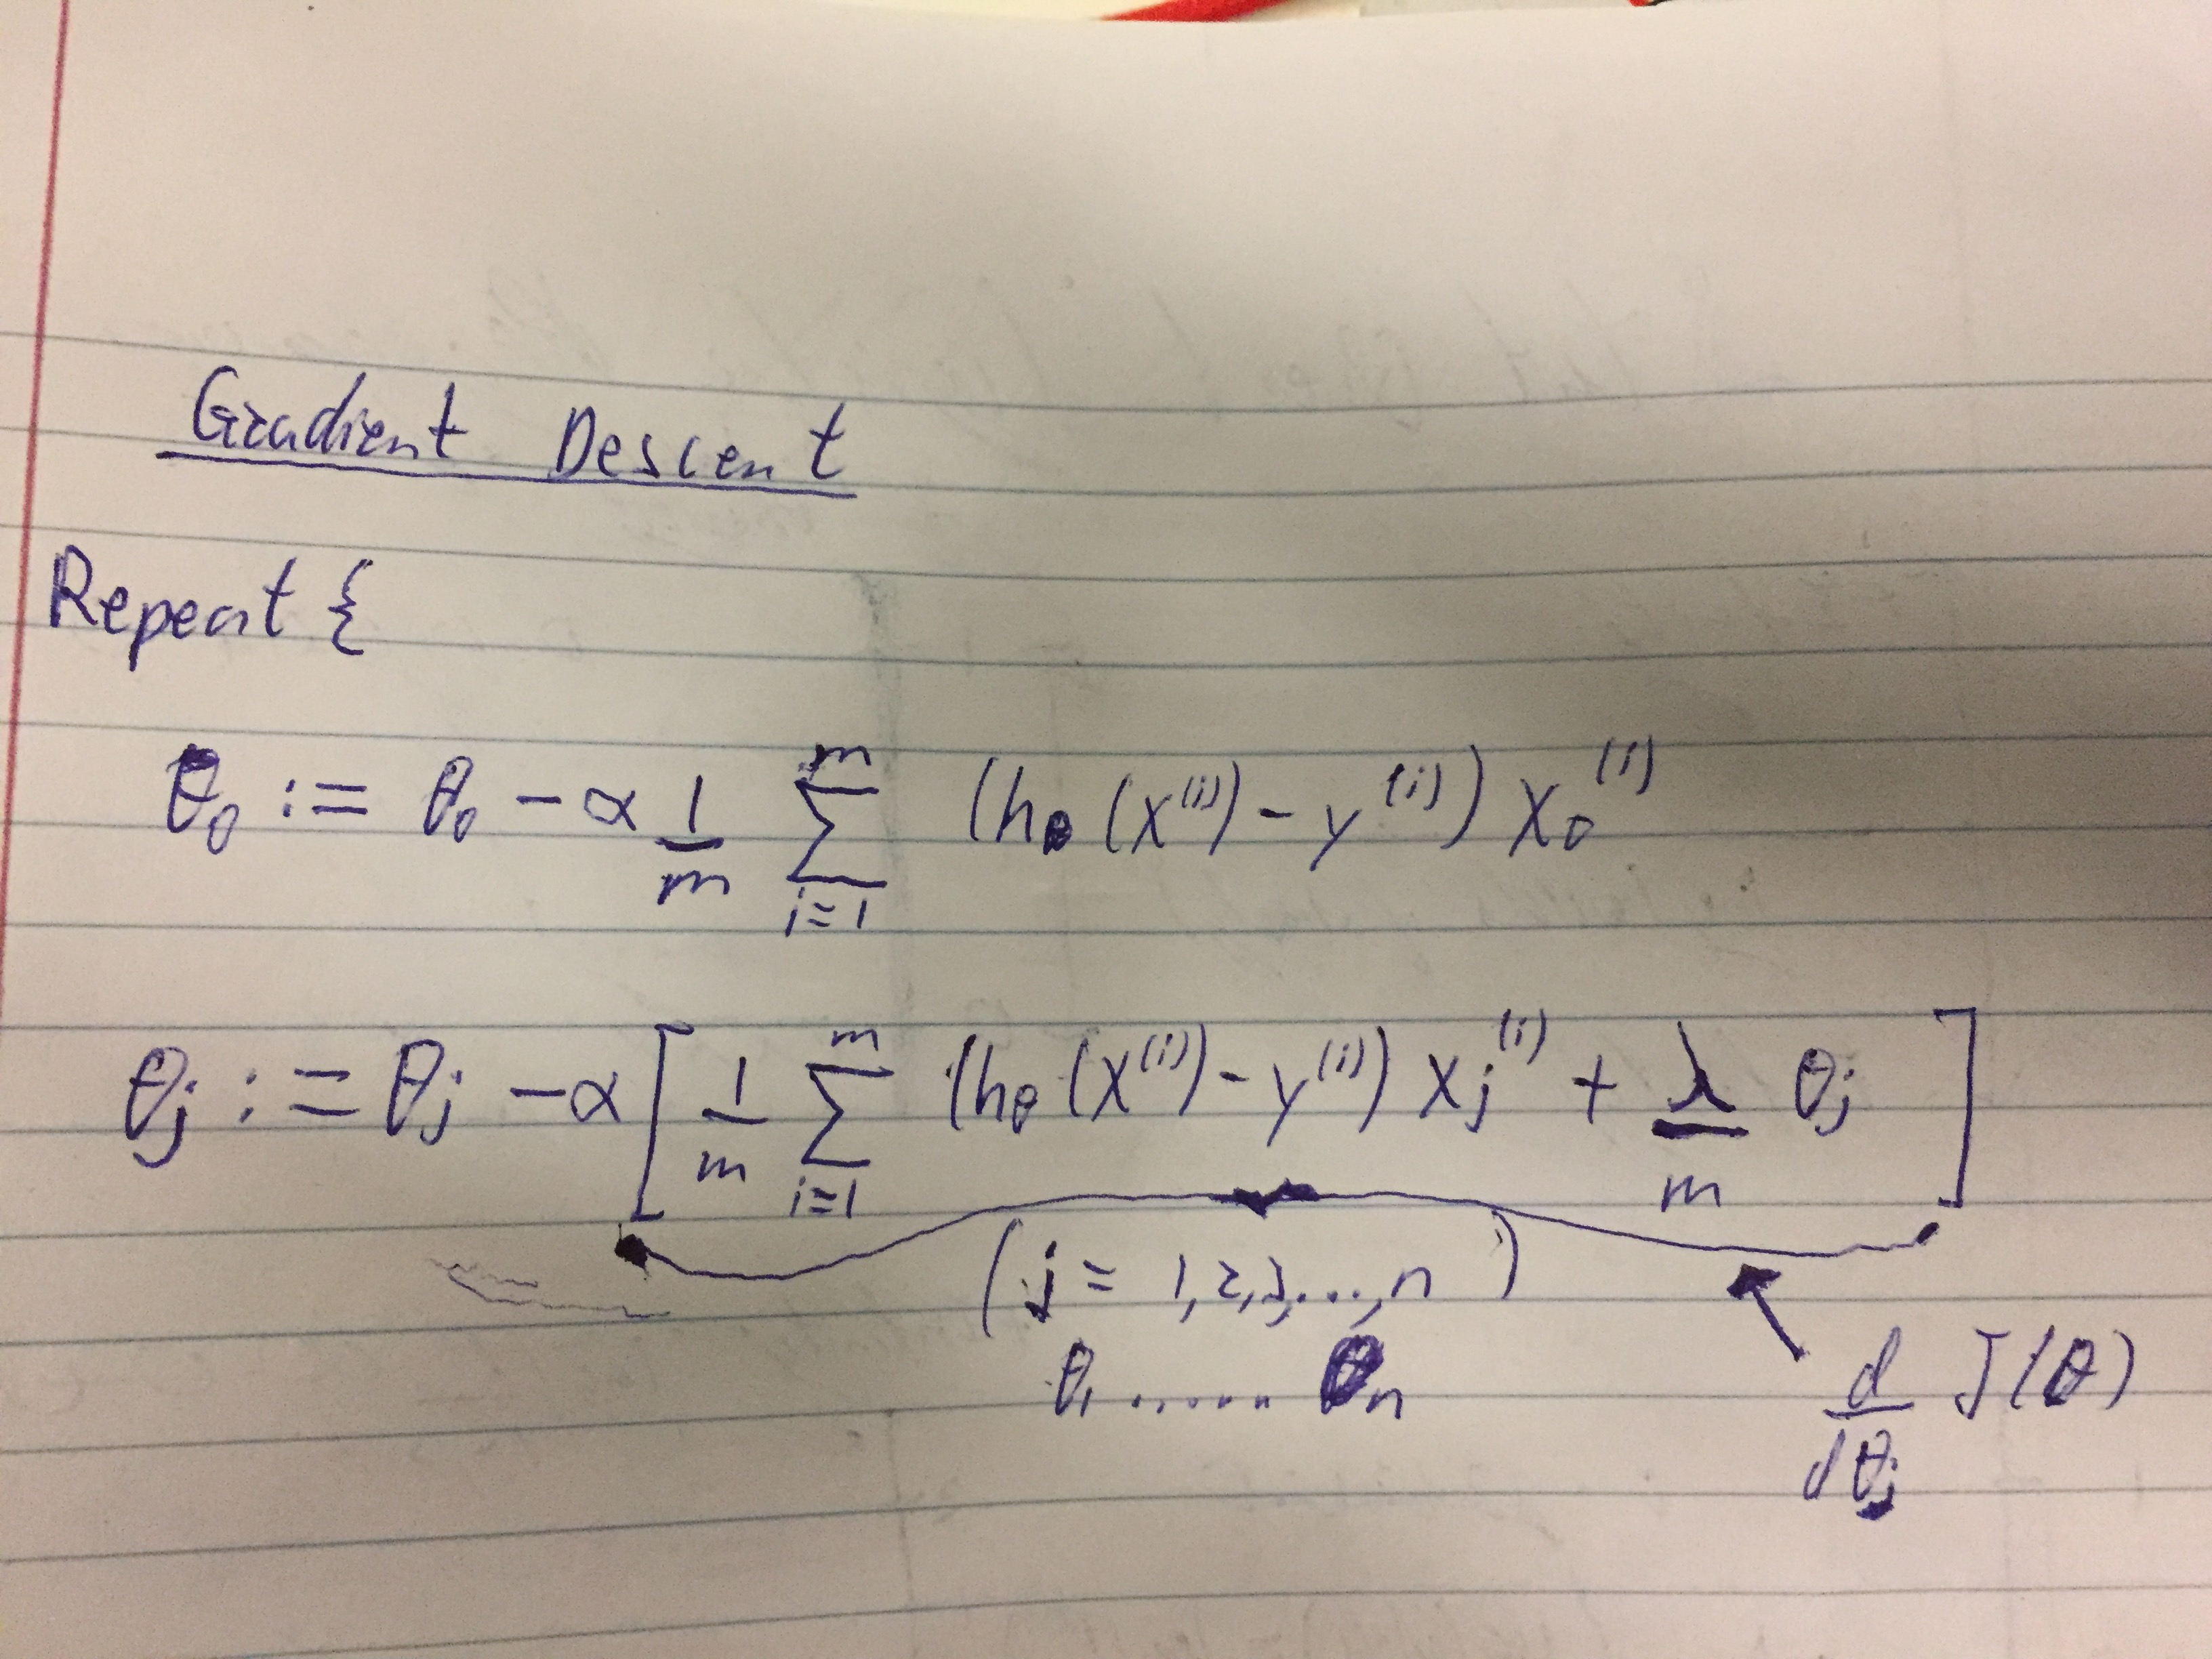

In [8]:
# Logistic Regression Gradient Descent
Image("IMG_0340.JPG", width=500, height=70)

In [9]:
# Computing gradient for logistic regression cost function
# Octave equivalent function of "fmincg" provided in the assignment is "fmin_cg"
# "fmin_cg" has a parameter that requires the gradient of f at x.

# X.shape = (5000,401)

def gradient_cost(my_theta, my_X, my_y, my_lambda=0.):
    m = X.shape[0]
    # Tranpose y here because it makes the units work out in dot products later
    beta = hypothesis(my_theta,my_X) - my_y.T #shape = (5000,5000)
    regterm = (my_lambda/m)*my_theta[1:] #shape = (400,1) | skip theta 0 for regularization
    
    grad = (1./m) * np.dot(my_X.T, beta) #Shape = (401,5000)
    
    grad[1:] = grad[1:] + regterm
    
    return grad #Shape = (401,5000)

In [10]:
def optimize_theta(my_theta, my_X, my_y, my_lambda=0.):
    result = optimize.fmin_cg(cost_function, fprime=gradient_cost, x0=my_theta, \
                              args=(my_X, my_y, my_lambda), maxiter=50, disp=False,\
                              full_output=True)
    return result[0], result[1]

In [11]:
def build_theta():
    """
    Function that determines an optimized theta for each class
    and returns a Theta function where each row corresponds
    to the learned logistic regression params for one class
    """
    my_lambda = 0.
    initial_theta = np.zeros((X.shape[1],1)).reshape(-1) #Shape = (401,)
    Theta = np.zeros((10, X.shape[1])) #Shape = (10, 401)
    for i in range(10):
        iclass = i if i else 10 #class "10" corresponds to handwritten zero
        print ("Optimizing for handwritten number %d..."%i)
        
        #converting y into 1 or 0
        logic_Y = np.array([1 if x==iclass else 0 for x in y]) #.reshape((X.shape[0],1))
        itheta, imincost = optimize_theta(initial_theta,X,logic_Y,my_lambda) #optimizing for theta
        Theta[i,:] = itheta
    print ("Done!")
    return Theta    

# Each class represents a possible outcome. Since there are 10 numbers, there are 10 classes

In [12]:
Theta = build_theta()

Optimizing for handwritten number 0...
Optimizing for handwritten number 1...
Optimizing for handwritten number 2...
Optimizing for handwritten number 3...
Optimizing for handwritten number 4...
Optimizing for handwritten number 5...
Optimizing for handwritten number 6...
Optimizing for handwritten number 7...
Optimizing for handwritten number 8...
Optimizing for handwritten number 9...
Done!


#### Andrew Ng's One vs All Classification Example

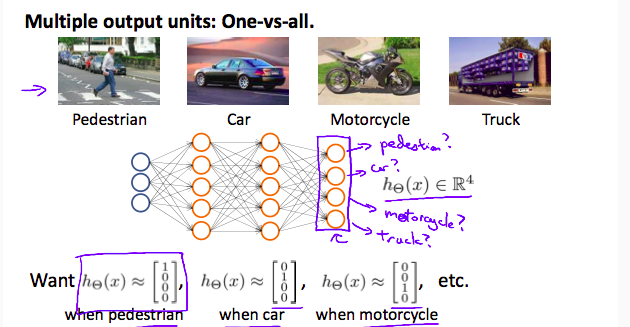

In [13]:
Image("One-vs-all1.png", width=500, height=200)

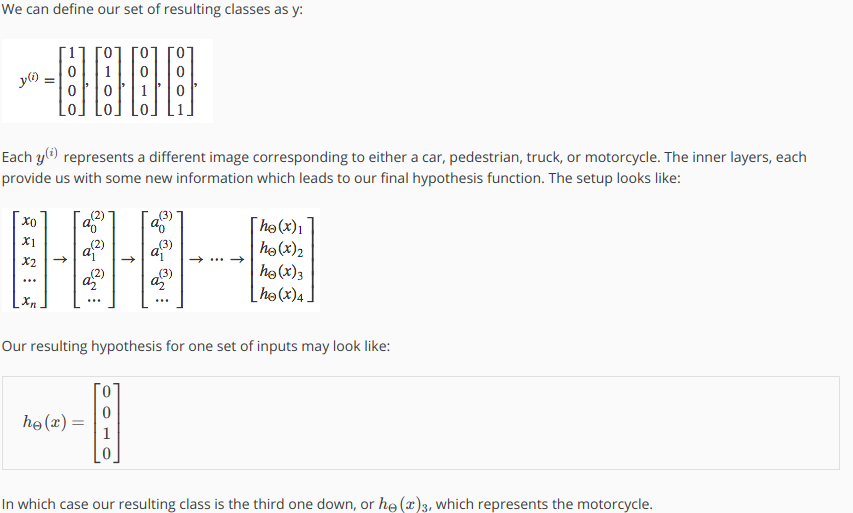

In [135]:
Image("One-vs-all2.png", width=600, height=400)

In [136]:
def predict_OnevsAll(my_theta,row):
    """
    Function that computes a hypothesis for an individual image (row in X)
    and returns the predicted integer corresponding to the handwritten image
    """
    classes = [10] + [1,2,3,4,5,6,7,8,9]
    hypoth = [0]*len(classes)
    #Compute a hypothesis for each possible outcome
    #Choose the maximum hypothesis to find result
    for i in range(len(classes)):
        hypoth[i] = hypothesis(my_theta[i],row)
    return classes[np.argmax(np.array(hypoth))]

In [137]:
# "You should see that the training set accuracy is about 94.9%"
n_correct, n_total = 0., 0.
incorrect_indices = []
for irow in range(X.shape[0]):
    n_total += 1
    if predict_OnevsAll(Theta,X[irow]) == y[irow]: 
        n_correct += 1
    else: incorrect_indices.append(irow)
print ("Training set accuracy: %0.1f%%"%(100*(n_correct/n_total)))

Training set accuracy: 95.3%


/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


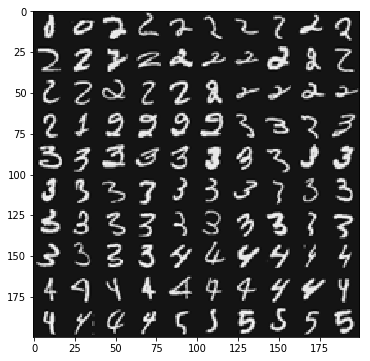

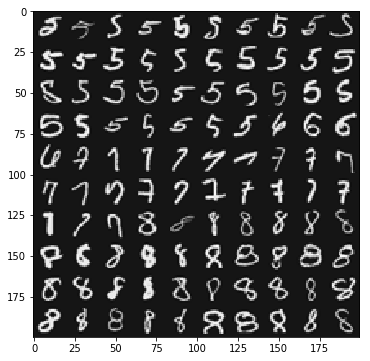

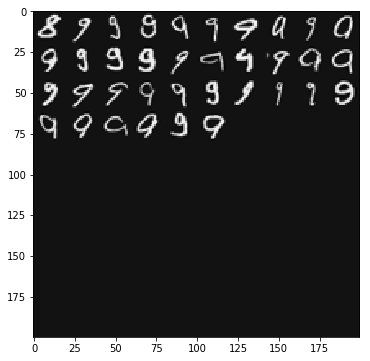

In [138]:
# we ones that we get wrong:
display_data(incorrect_indices[:100])
display_data(incorrect_indices[100:200])
display_data(incorrect_indices[200:300])

## 2. Neural Networks

#### Neural Network Basics

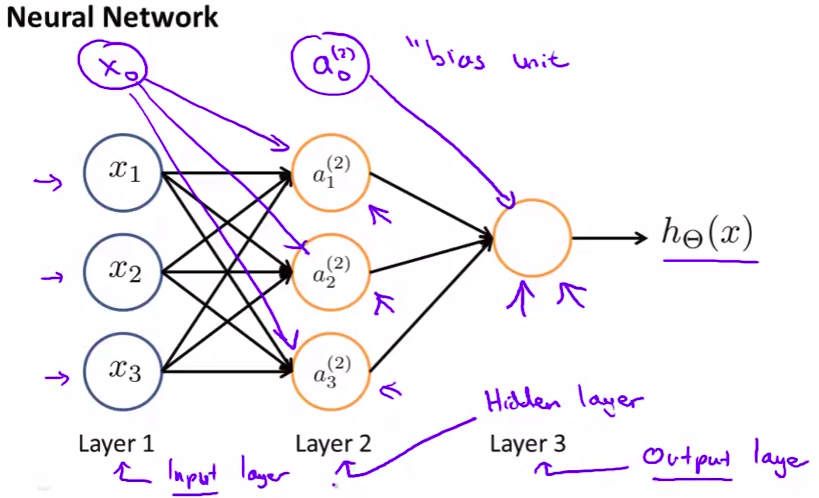

In [139]:
Image("Neural_Network2.png", width=350, height=150)

# The 1st layer is the input layer, last year is the output layer
# all other layers in between are called hidden layers

# Neural Network is just like logistic regression. But instead of using the original features x1,x2,x3,...
# ...its using the new features a1,a2,a3. 
# The features a1,a2,a3 they are learned as function of the input

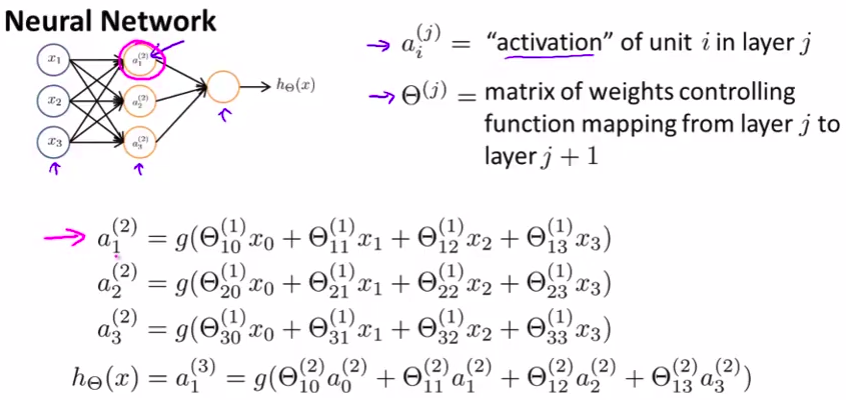

In [140]:
Image("Neural_Network3.png", width=500, height=300)

#### Model representation

In [141]:
#You have been provided with a set of network parameters (Θ(1),Θ(2)) 
#already trained by us. These are stored in ex3weights.mat
datafile = 'ex3weights.mat'
mat = scipy.io.loadmat( datafile )
Theta1, Theta2 = mat['Theta1'], mat['Theta2']
print ("Theta1 has shape:",Theta1.shape)
print ("Theta2 has shape:",Theta2.shape)

Theta1 has shape: (25, 401)
Theta2 has shape: (10, 26)


#### Forward Propagation

In [142]:
def propagateForward(row,Thetas):
    """
    Function that given a list of Thetas, propagates the
    Row of features forwards, assuming the features already
    include the bias unit in the input layer, and the 
    Thetas need the bias unit added to features between each layer
    """
    features = row
    for i in range(len(Thetas)): #iterating through each theta
        Theta = Thetas[i] 
        
        #multiplying each theta by each feature | (25, 401)*(401,) becomes (25,)
        z = Theta.dot(features)
        
        #applying the sigmoid function | a shape = (25,)
        a = expit(z)
        
        #len of Theta1 and Theta2 are 25 and 10 respectively
        if i == len(Thetas)-1:
            return a
        
        # a.shape becomes (26,)
        # np.insert documentation: https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.insert.html
        a = np.insert(a,0,1) #Add the bias unit
        features = a # "a" becomes the new activation unit

def predictNN(row,Thetas):
    """
    Function that takes a row of features, propagates them through the
    NN, and returns the predicted integer that was hand written
    """
    classes = [1,2,3,4,5,6,7,8,9,10]
    output = propagateForward(row,Thetas)
    return classes[np.argmax(np.array(output))]

In [143]:
# "You should see that the accuracy is about 97.5%"
myThetas = [ Theta1, Theta2 ]
n_correct, n_total = 0., 0.
incorrect_indices = []

for irow in range(X.shape[0]): #iterating through each of the 5000 training examples
    n_total += 1 #tallying the number of iterations, up to 5000 in this case
    if predictNN(X[irow],myThetas) == int(y[irow]): #if predicted number = actual number (y)
        n_correct += 1 #tallying the number of correct predictions
    else: incorrect_indices.append(irow) #tallying the number of incorrect predictions
print ("Training set accuracy: %0.1f%%"%(100*(n_correct/n_total)))

Training set accuracy: 97.5%


/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  """


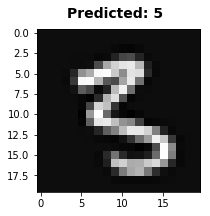

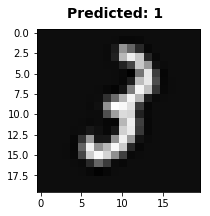

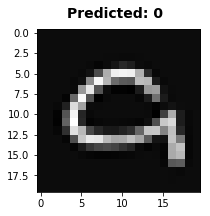

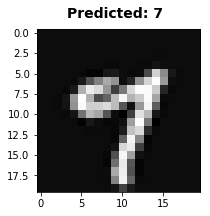

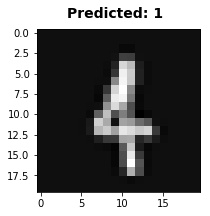

In [144]:
#Pick some of the images we got WRONG and look at them, just to see
for x in range(5):
    i = random.choice(incorrect_indices)
    fig = plt.figure(figsize=(3,3))
    img = scipy.misc.toimage( get_img(X[i]) )
    plt.imshow(img,cmap = cm.Greys_r)
    predicted_val = predictNN(X[i],myThetas)
    predicted_val = 0 if predicted_val == 10 else predicted_val
    fig.suptitle('Predicted: %d'%predicted_val, fontsize=14, fontweight='bold')